# 은행 마케팅 데이터셋을 활용한 분류기 만들기
-  `분류(classification)`: 새로운 관측값이 주어졌을 때, 그 관측값이 미리 정의된 여러 범주(하위 집단) 중 어느 하나에 속하는지를 결정하는 문제
- 은행 마케팅 데이터셋을 사용하여, 몇 가지 속성에 따라 누군가가 예금을 할지 여부를 예측하는 모델을 만들어 보겠습니다.
- 각 모델을 구축한 후, 모델을 평가하고 우리 사례에 가장 적합한 모델이 무엇인지 비교해보겠습니다.
- GridSearch를 사용해 모델의 하이퍼파라미터를 튜닝하여 모델을 최적화해 보겠습니다. 데이터셋에서 나온 예측 결과를 저장하고, 나중에 다시 사용할 수 있도록 모델을 저장할 것입니다.

In [4]:
!pip install seaborn scikit-learn

In [5]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)

# 1. Preprocessing


## 가. Loading data

- https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

### 독립변수:
1. 개인정보
    - age (숫자형): 나이
    - job: 직업 유형 (범주형: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    - marital: 결혼 상태 (범주형: 'divorced','married','single','unknown'; 참고: 'divorced'는 이혼 또는 사별을 의미함)
    - education: 교육 수준 (범주형: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
    - default: 연체된 대출이 있는지 여부 (범주형: 'no','yes','unknown')
    - housing: 주택 대출이 있는지 여부 (범주형: 'no','yes','unknown')
    - loan: 개인 대출이 있는지 여부 (범주형: 'no','yes','unknown')
    --------------------
2. 마케팅 관련 정보
    - contact: 연락 방식 (범주형: 'cellular','telephone')
    - month: 마지막 연락 월 (범주형: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    - day_of_week: 마지막 연락 요일 (범주형: 'mon','tue','wed','thu','fri')
    - duration: 마지막 연락 시간(초 단위, 숫자형).
        - 중요한 주의사항: 이 속성은 출력(target)에 큰 영향을 미침 (예: duration=0이면 y='no'). 그러나 통화가 이루어지기 전에는 duration을 알 수 없고, 통화가 끝나면 y값은 명확해짐. 따라서 이 속성은 벤치마크 목적으로만 포함되어야 하며, 현실적인 예측 모델을 만들 때는 제외해야 함.
    - campaign: 이번 캠페인에서 해당 고객에게 이루어진 연락 횟수 (숫자형, 마지막 연락 포함)
    - pdays: 이전 캠페인에서 고객에게 마지막으로 연락한 후 경과한 일수 (숫자형; 999는 이전에 연락하지 않은 경우를 의미)
    - previous: 이번 캠페인 전에 해당 고객에게 이루어진 연락 횟수 (숫자형)
    - poutcome: 이전 마케팅 캠페인의 결과 (범주형: 'failure','nonexistent','success')

### 종속변수(target, 예측 대상):
- y: 고객이 정기 예금을 신청했는지 여부 (이진형: 'yes','no')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Load dataset
df_bank = pd.read_csv('/content/drive/MyDrive/bank.csv')

In [8]:
df_bank.info()
df_bank.describe().T
df_bank.describe(include='all').T
# 'duration' 컬럼 버리기(drop)

# print(df_bank.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,11162.0,NaN,NaN,NaN,41.231948,11.913369,18.0,32.0,39.0,49.0,95.0
job,11162,12,management,2566,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,11162,3,married,6351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,11162,4,secondary,5476,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,11162,2,no,10994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,11162.0,NaN,NaN,NaN,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.0,81204.0
housing,11162,2,no,5881,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,11162,2,no,9702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,11162,3,cellular,8042,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,11162.0,NaN,NaN,NaN,15.658036,8.42074,1.0,8.0,15.0,22.0,31.0


## EDA

### 가. TARGET 클래스의 분포 확인

In [9]:
df_bank['deposit'].value_counts()

,count
deposit,
no,5873
yes,5289


### 나. 결측값 확인
- `isnull()` 또는 `sum()` 으로 결측값을 확인합니다.

In [10]:
df_bank.isnull().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


- 또는 missingno 라는 패키지를 이용할 수도 있습니다.

<Axes: >

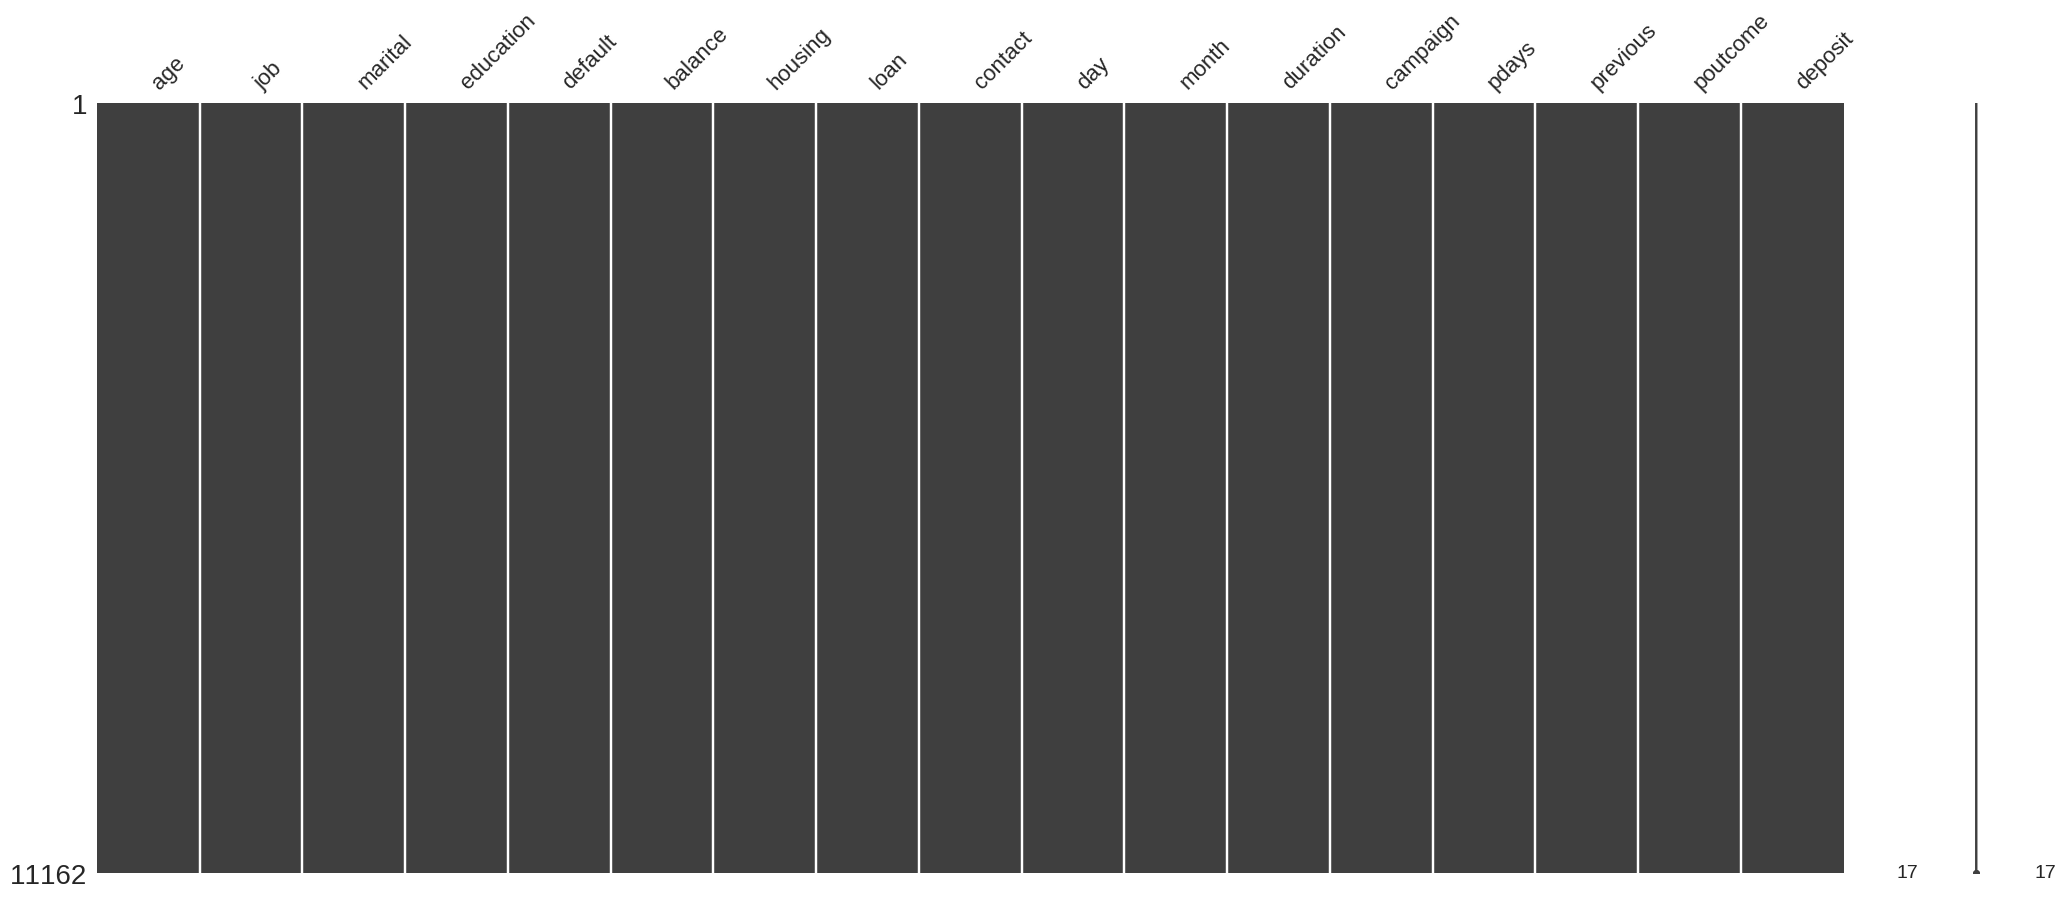

In [11]:
!pip install missingno
import missingno as msno

msno.matrix(df_bank)

### 수치형 데이터 스케일링

- StandardScaler는 이상치에 덜 민감합니다. 이는 데이터에 이상치가 포함되어 있을 때 유리합니다. 또한 데이터의 분포를 유지하면서 스케일링을 수행하므로, 데이터의 상대적인 크기와 분포를 유지할 수 있습니다.

<div align="center">$Z = \frac{X - U}{S}$</div>

*Where:*

*$Z:$ scaled value*

*$X:$ original value*

*$U:$ mean of the data*

*$S:$ standard deviation of the data*


- 참고
    - StandardScaler 외에도 다양한 스케일링 방법이 있습니다. 각 방법은 데이터의 특성과 모델의 요구사항에 따라 선택할 수 있습니다.

    - 1) MinMaxScaler:
        ```
        데이터의 최소값을 0, 최대값을 1로 변환합니다.
        이상치에 민감할 수 있습니다.
        주로 신경망 모델에서 사용됩니다.

        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df_bank_ready[num_cols])
        ```

    - 2) RobustScaler:
        ```
        중앙값(median)과 IQR(Interquartile Range)을 사용하여 스케일링합니다.
        이상치에 덜 민감합니다.

        from sklearn.preprocessing import RobustScaler
        scaler = RobustScaler()
        scaled_data = scaler.fit_transform(df_bank_ready[num_cols])
        ```

    - 3) MaxAbsScaler:
        ```
        각 특징의 절대 최대값을 1로 스케일링합니다.
        양수와 음수의 데이터가 혼합된 경우 유용합니다.

        from sklearn.preprocessing import MaxAbsScaler
        scaler = MaxAbsScaler()
        scaled_data = scaler.fit_transform(df_bank_ready[num_cols])
        ```

    - 4) Normalizer:
        ```
        각 샘플의 벡터 크기를 1로 스케일링합니다.
        주로 텍스트 데이터나 신경망의 입력 데이터에 사용됩니다.

        from sklearn.preprocessing import Normalizer
        scaler = Normalizer()
        scaled_data = scaler.fit_transform(df_bank_ready[num_cols])
        ```


In [13]:
df_bank_ready.info() # age, balance, day, campaign, pdays, previous

NameError: name 'df_bank_ready' is not defined

In [14]:
from sklearn.preprocessing import StandardScaler
pd.options.display.float_format = '{:.2e}'.format

# bank_df를 복제해 놓고 복제한 테이블에 작업을 시작

df_bank_ready = df_bank.copy()
df_bank_ready = df_bank_ready.drop('duration', axis=1)  # duration은 사후에 기록된 컬럼이기 때문에, 앞으로의 예측에서는 수집할 수 없는 데이터

# 스케일러 객체 만든다
sc = StandardScaler()
num_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

# 스케일러 객체에 fit 한다
df_bank_ready[num_cols] = sc.fit_transform(df_bank_ready[num_cols])

# 스케일러 객체에 transform 한다

In [15]:
df_bank_ready.describe()

,age,balance,day,campaign,pdays,previous
count,1.12e+04,1.12e+04,1.12e+04,1.12e+04,1.12e+04,1.12e+04
mean,2.75e-16,1.02e-17,-2.04e-17,3.06e-17,5.09e-18,-2.04e-17
std,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00
min,-1.95e+00,-2.60e+00,-1.74e+00,-5.54e-01,-4.81e-01,-3.63e-01
25%,-7.75e-01,-4.36e-01,-9.09e-01,-5.54e-01,-4.81e-01,-3.63e-01
50%,-1.87e-01,-3.03e-01,-7.81e-02,-1.87e-01,-4.81e-01,-3.63e-01
75%,6.52e-01,5.56e-02,7.53e-01,1.81e-01,-2.81e-01,7.31e-02
max,4.51e+00,2.47e+01,1.82e+00,2.22e+01,7.38e+00,2.49e+01


In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_bank_ready[num_cols])

In [17]:
pd.DataFrame(scaled_data).describe()

,0,1,2,3,4,5
count,1.12e+04,1.12e+04,1.12e+04,1.12e+04,1.12e+04,1.12e+04
mean,3.02e-01,9.51e-02,4.89e-01,2.43e-02,6.12e-02,1.44e-02
std,1.55e-01,3.66e-02,2.81e-01,4.39e-02,1.27e-01,3.95e-02
min,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
25%,1.82e-01,7.91e-02,2.33e-01,0.00e+00,0.00e+00,0.00e+00
50%,2.73e-01,8.40e-02,4.67e-01,1.61e-02,0.00e+00,0.00e+00
75%,4.03e-01,9.72e-02,7.00e-01,3.23e-02,2.54e-02,1.72e-02
max,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00,1.00e+00


## 범주형 변수(Categorical Value) 인코딩

숫자 데이터와 마찬가지로, 컴퓨터가 이해하기 쉽도록 카테고리 데이터를 숫자로 전처리할 필요가 있습니다. 이를 위해 sklearn에서 제공하는 OneHotEncoder()를 사용합니다. 이 방법은 카테고리 열을 다음과 같이 변환합니다.

| marital | housing |
|----------|---------|
| single   | yes     |
| divorced | no      |
| married  | no      |

...위 컬럼이 yes -> 1, no -> 0 를 거쳐 아래와 같이 변환됩니다...

| marital_single | marital_divorced | marital_married | housing_yes | housing_no |
|----------------|------------------|-----------------|-------------|------------|
| 1              | 0                | 0               | 1           | 0          |
| 0              | 1                | 0               | 0           | 1          |
| 0              | 0                | 1               | 0           | 1          |



In [18]:
# single = 0 , divorced = 1, married = 2    명목형 변수  -하나의 항목에 전부를 계산하게 되면 숫자 자체가 의미를 지닌다 라고 착각할 수 있게 됩니다.
# ..... w13x13 + w14x14 + w15x15 +
# single = 0

# 5 4 3 2 1  명목형 변수 - 서수형변수 숫자가 의미를 경우 Label Encoder로
# ... . w13x13  ....

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# OneHot 인코딩으로 범주형 변수를 숫자로 변환
encoder = OneHotEncoder()
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'] # 문자열로 된 컬럼들을 0, 1, 2

df_encoded = pd.DataFrame(encoder.fit_transform(df_bank_ready[cat_cols]).toarray())
df_encoded.columns = encoder.get_feature_names_out(cat_cols)
df_encoded


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00e+00,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00
1,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00e+00,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00
2,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,...,0.00e+00,0.00e+00,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00
3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00e+00,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00
4,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00e+00,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0.00e+00,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00
11158,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,0.00e+00,0.00e+00,...,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00
11159,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,...,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00
11160,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,...,0.00e+00,0.00e+00,1.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,0.00e+00,0.00e+00,0.00e+00


In [19]:
# df_bank_ready에 합쳐줍니다.
df_bank_ready = df_bank_ready.drop(cat_cols, axis=1)
df_bank_ready = pd.concat([df_encoded, df_bank_ready], axis=1)
df_bank_ready.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,campaign,pdays,previous,deposit
0,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00e+00,1.00e+00,1.49e+00,2.53e-01,-1.27e+00,-5.54e-01,-4.81e-01,-3.63e-01,yes
1,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00e+00,1.00e+00,1.24e+00,-4.60e-01,-1.27e+00,-5.54e-01,-4.81e-01,-3.63e-01,yes
2,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,...,0.00e+00,0.00e+00,1.00e+00,-1.95e-02,-8.02e-02,-1.27e+00,-5.54e-01,-4.81e-01,-3.63e-01,yes
3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00e+00,1.00e+00,1.16e+00,2.94e-01,-1.27e+00,-5.54e-01,-4.81e-01,-3.63e-01,yes
4,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00e+00,1.00e+00,1.07e+00,-4.17e-01,-1.27e+00,-1.87e-01,-4.81e-01,-3.63e-01,yes


In [20]:
# deposit  yes =1 , no = 0으로 수치형 변환이 필요합니다.
df_bank_ready['deposit'] = df_bank_ready['deposit'].apply(lambda x: 1 if x =='yes' else 0)
df_bank_ready.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,campaign,pdays,previous,deposit
0,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00e+00,1.00e+00,1.49e+00,2.53e-01,-1.27e+00,-5.54e-01,-4.81e-01,-3.63e-01,1
1,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00e+00,1.00e+00,1.24e+00,-4.60e-01,-1.27e+00,-5.54e-01,-4.81e-01,-3.63e-01,1
2,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,...,0.00e+00,0.00e+00,1.00e+00,-1.95e-02,-8.02e-02,-1.27e+00,-5.54e-01,-4.81e-01,-3.63e-01,1
3,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,1.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00e+00,1.00e+00,1.16e+00,2.94e-01,-1.27e+00,-5.54e-01,-4.81e-01,-3.63e-01,1
4,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,...,0.00e+00,0.00e+00,1.00e+00,1.07e+00,-4.17e-01,-1.27e+00,-1.87e-01,-4.81e-01,-3.63e-01,1


In [21]:
encoder.categories_

[array(['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
        'retired', 'self-employed', 'services', 'student', 'technician',
        'unemployed', 'unknown'], dtype=object),
 array(['divorced', 'married', 'single'], dtype=object),
 array(['primary', 'secondary', 'tertiary', 'unknown'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['cellular', 'telephone', 'unknown'], dtype=object),
 array(['apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may',
        'nov', 'oct', 'sep'], dtype=object),
 array(['failure', 'other', 'success', 'unknown'], dtype=object)]

In [22]:
dir(encoder)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_build_request_for_signature',
 '_check_X',
 '_check_feature_names',
 '_check_get_feature_name_combiner',
 '_check_infrequent_enabled',
 '_check_n_features',
 '_compute_n_features_outs',
 '_compute_transformed_categories',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_drop_idx_after_grouping',
 '_fit',
 '_fit_infrequent_category_mapping',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_identify_infrequent',
 '_infrequent_enabled',
 '_map_drop_idx_to_inf

In [23]:
df_bank_ready[cat_cols]

KeyError: "None of [Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',\n       'month', 'poutcome'],\n      dtype='object')] are in the [columns]"

### 다. 데이터셋 분리

 - 훈련과 테스트 데이터를 각각 80:20 비율로 나눕니다.

In [24]:
# 특성 선택
feature = df_bank_ready.drop('deposit', axis=1)

# 타겟 선택
target = df_bank_ready['deposit']

feature.shape, target.shape
# 훈련 데이터와 테스트 데이터 설정
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, shuffle=True, random_state=121)

# 훈련 데이터와 테스트 데이터 출력
print('훈련 특성:', X_train.shape)
print('테스트 특성:', X_test.shape)
print('훈련 라벨:', y_train.shape)
print('테스트 라벨:', y_test.shape)

훈련 특성: (8929, 50)
테스트 특성: (2233, 50)
훈련 라벨: (8929,)
테스트 라벨: (2233,)


### 라. 정규화(스케일링)


In [25]:
from sklearn.preprocessing import StandardScaler

# 정규화를 위해 스케일러 사용
scaler = StandardScaler()

# 훈련 데이터에 대해서만 fit하고, 훈련 및 테스트 데이터에 변환 적용
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


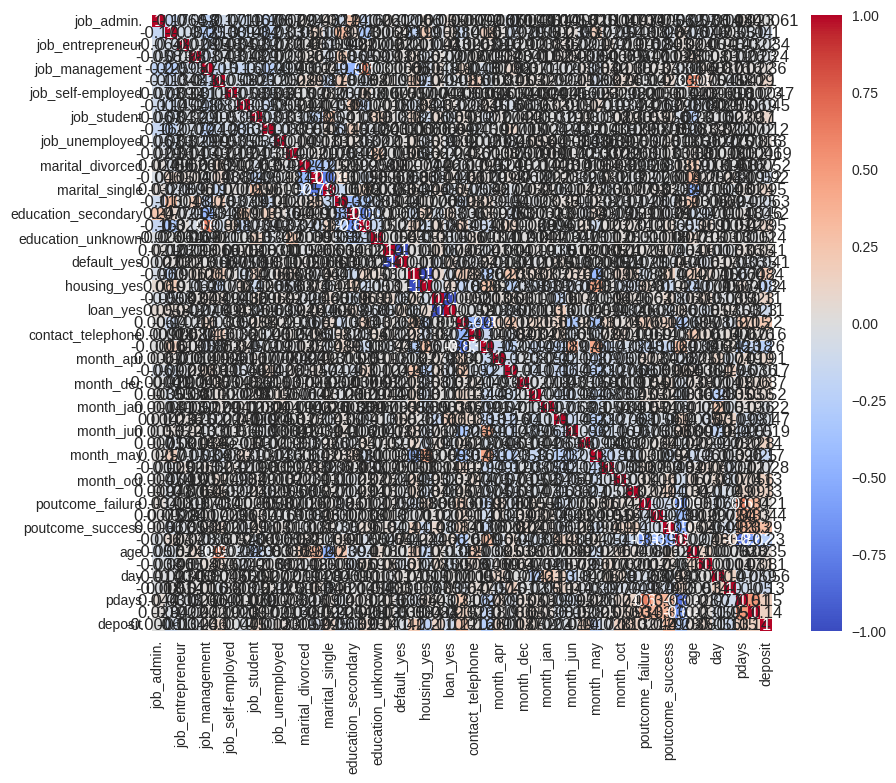

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관관계 행렬 계산
corr_matrix = df_bank_ready.corr()

# 상관계수 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


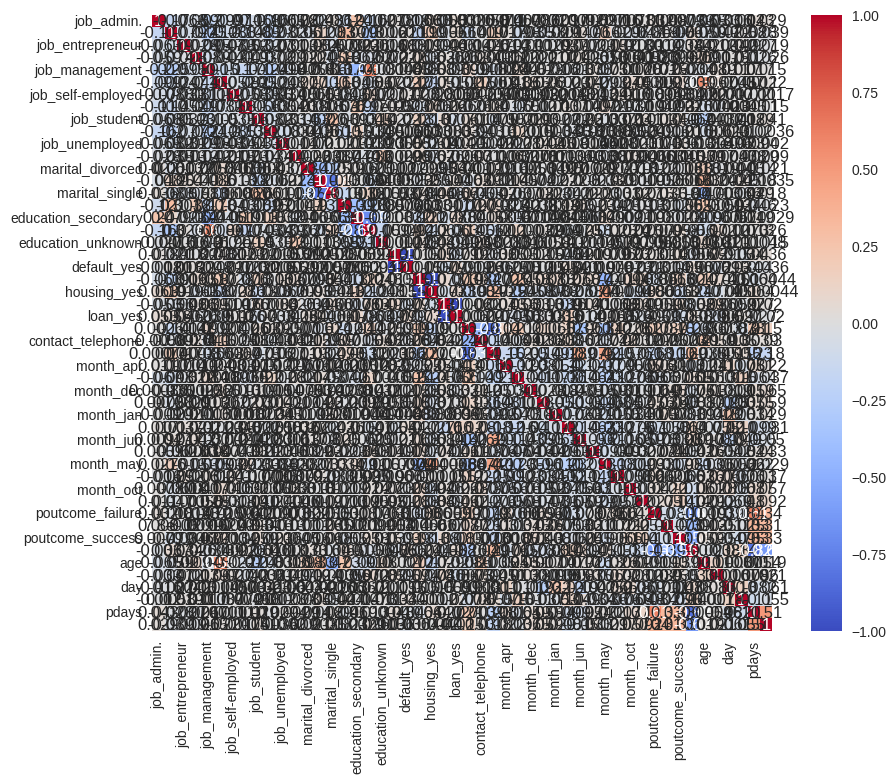

In [26]:
# 상관관계 분석을 통해 상관관계가 높은 피처 제거
import seaborn as sns
import matplotlib.pyplot as plt

# 피어슨 상관관계 행렬
corr_matrix = pd.DataFrame(X_train).corr()

# 상관계수 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# 상관관계 기준으로 피처 선택 (예: 상관계수 0.8 이상 제거)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
X_train_reduced = X_train.drop(columns=to_drop)
X_test_reduced = X_test.drop(columns=to_drop)


In [46]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤 포레스트 모델 학습
model = RandomForestClassifier()
model.fit(X_train, y_train)

# 피처 중요도 출력
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # 중요도가 높은 순으로 정렬
for i in indices:
    print(f"{X_train.columns[i]}: {importances[i]}")


balance: 0.14958095161220988
age: 0.13257783168757042
day: 0.1160864253594652
campaign: 0.06702999868879123
pdays: 0.041025532413658625
poutcome_success: 0.038861659368633984
previous: 0.02821997913286015
contact_unknown: 0.023872852601953137
contact_cellular: 0.01907440495339312
housing_no: 0.0176331265042514
education_secondary: 0.015729000677804156
job_technician: 0.014513149998400652
housing_yes: 0.014507263717946453
marital_married: 0.014437863409011036
month_may: 0.014158415841680563
month_apr: 0.014117223330605734
job_blue-collar: 0.013741691477275882
education_tertiary: 0.013687845817441384
job_management: 0.013573569267540277
marital_single: 0.01332092164127055
month_aug: 0.012318513277218104
job_admin.: 0.011935502180773622
month_jun: 0.01128234997086573
education_primary: 0.010507799555079304
month_nov: 0.010423815025921443
loan_yes: 0.010405092580205312
month_jul: 0.010381501055779655
job_services: 0.010372043854524345
loan_no: 0.010342353290956225
month_oct: 0.010208322973

선택된 피처들:
0              job_admin.
1         job_blue-collar
4          job_management
7            job_services
9          job_technician
13        marital_married
14         marital_single
15      education_primary
16    education_secondary
17     education_tertiary
21             housing_no
22            housing_yes
23                loan_no
24               loan_yes
25       contact_cellular
27        contact_unknown
28              month_apr
29              month_aug
33              month_jul
34              month_jun
35              month_mar
36              month_may
37              month_nov
38              month_oct
42       poutcome_success
44                    age
45                balance
46                    day
47               campaign
48                  pdays
49               previous
Name: Feature, dtype: object


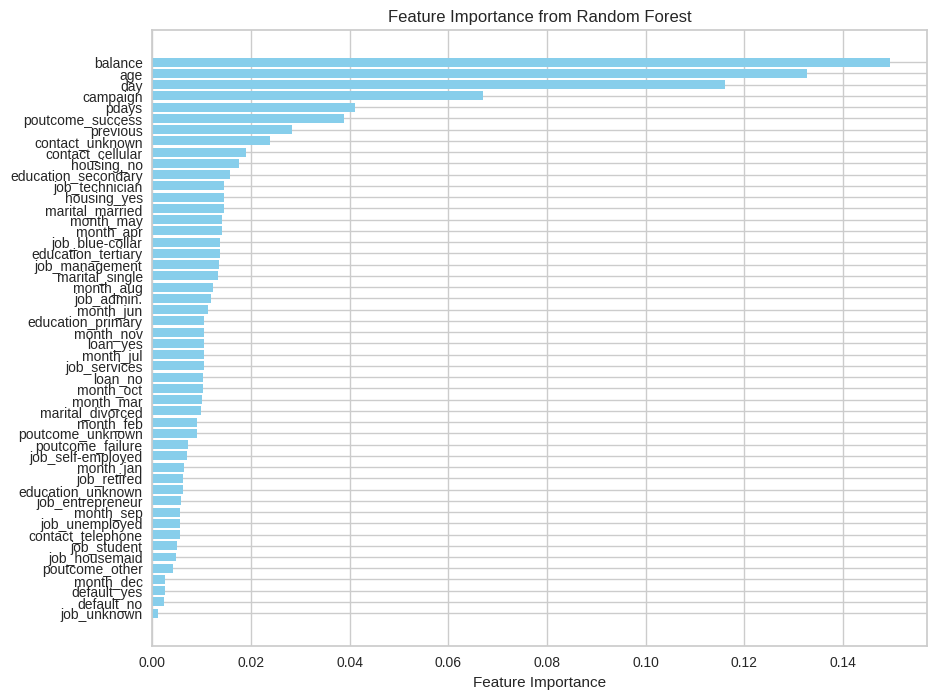

In [48]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# 1. 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# 2. 피처 중요도 추출
feature_importances = rf_model.feature_importances_

# 3. 피처 중요도와 피처 이름을 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# 4. 중요도 기준으로 피처 선택 (중요도 0.01 이상인 피처)
selected_features = importance_df[importance_df['Importance'] > 0.01]['Feature']

# 선택된 피처 출력
print("선택된 피처들:")
print(selected_features)

# 5. 피처 중요도 시각화 (선택사항)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # 중요도 높은 순으로 정렬
plt.show()


# 3. 모델링

이 단계에서는 각 알고리즘에 대해 기본 파라미터를 사용하여 기준 모델을 만들고, 4개의 모델을 모두 구축한 후 어떤 모델이 가장 잘 작동하는지 비교할 것입니다.

모델을 평가하기 위해, 기본 평가 지표로 혼동 행렬을 사용하겠습니다.

<div align='center'><img src='https://miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png' height='250'></div>
- TP = True Positive (진짜 양성)
- FP = False Positive (거짓 양성)
- TN = True Negative (진짜 음성)
- FN = False Negative (거짓 음성)

- 분류 모델을 평가하기 위해 다음의 5가지 지표를 사용합니다.

1) 정확도 (Accuracy): 전체 사례 중에서 진짜 결과의 비율입니다.
<div align='center'>$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$</div>


2) 정밀도 (Precision): 예측한 양성 중 실제로 양성인 비율을 계산하는 데 사용됩니다.
<div align='center'>$Precision = \frac{TP}{TP+FP}$</div>

3) 재현율 (Recall): 실제 양성 중에서 올바르게 분류된 비율을 계산하는 데 사용됩니다.
<div align='center'>$Recall = \frac{TP}{TP+FN}$</div>

4) F1 점수 (F1 Score): 0과 1 사이의 값으로, 정밀도와 재현율의 조화 평균입니다.
<div align='center'>$F1 = \frac{2TP}{2TP+FP+FN}$</div>

5) 곡선 아래 면적 (AUC): 양성 클래스의 확률이 음성 클래스와 얼마나 잘 구분되는지를 나타냅니다.


**우리가 분석하려는 도메인의 경우, 모델의 재현율 (Recall) 값을 주목해야 합니다.**
- 실제 양성을 가능한 한 많이 예측해야 하기 때문입니다. 실제로 예금하려는 고객을 잘못 분류하면 기회나 수익을 잃게 됩니다.

In [27]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1,
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

## 가. 의사결정 나무

의사결정 나무는 행동 방침을 결정하기 위해 사용되는 알고리즘입니다. 나무의 각 브랜치는 가능한 결정, 발생 또는 반응을 나타냅니다.

<div align='center'><img src='https://raw.githubusercontent.com/rafiag/DTI2020/main/images/decision_tree.PNG' height='250'></div>

장점:
* 구축 비용이 저렴함
* 처음보는 데이터를 분류하는 속도가 매우 빠름
* 해석하기 쉬움
* 많은 간단한 데이터 세트에 대해 다른 분류 기법과 비교할 만한 정확도를 가짐

단점:
* 알고리즘이 데이터의 노이즈를 포착할 때 과적합 발생
* 무작위성에 기대므로 데이터의 작은 변동으로 인해 모델이 불안정해질 수 있음

### Modeling

In [28]:
from sklearn import tree

# Decision Tree model 만들기

dtc = tree.DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [29]:
dtc.score(X_test, y_test)

0.6399462606359158

### Model Evaluation

In [30]:
# Evaluate Model
dtc_eval = evaluate_model(dtc, X_test, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

Accuracy: 0.6399462606359158
Precision: 0.6167279411764706
Recall: 0.6342155009451795
F1 Score: 0.625349487418453
Area Under Curve: 0.6396609419619514
Confusion Matrix:
 [[758 417]
 [387 671]]


## 나. Random Forest

- 여러 개의 의사결정 나무를 구성하여 작동하는 방법입니다. 다수의 나무의 결정을 최종 결정으로 선택합니다.

<div align='center'><img src='https://miro.medium.com/v2/resize:fit:1010/1*R3oJiyaQwyLUyLZL-scDpw.png' height='250'></div>


장점:
* 회귀 및 분류 작업 모두에 사용할 수 있으며, 입력 특징에 할당된 상대적 중요도를 쉽게 확인할 수 있습니다.
* 기본 하이퍼파라미터로도 좋은 예측 결과를 내기 때문에 매우 편리하고 사용하기 쉬운 알고리즘으로 간주됩니다.

단점:
* 많은 나무가 알고리즘을 느리고 실시간 예측에 비효율적으로 만들 수 있습니다. 더 정확한 예측은 더 많은 나무를 필요로 하며, 이는 더 느린 모델을 초래합니다.
* 예측 모델링 도구이며 설명 도구는 아닙니다.

### Modeling

In [31]:
from sklearn.ensemble import RandomForestClassifier

# Building Random Forest model
# Evaluate Model

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

rf_eval = evaluate_model(rf, X_test, y_test)

### Model Evaluation

In [32]:
# Evaluate Model

# Print result
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Accuracy: 0.7281683833407971
Precision: 0.7391304347826086
Recall: 0.6587901701323251
F1 Score: 0.6966516741629185
Area Under Curve: 0.7832614728713349
Confusion Matrix:
 [[929 246]
 [361 697]]


## 다. K-Nearest Neighbors

K-최근접 이웃(KNN)은 훈련 데이터에서 k개의 가장 가까운 이웃을 찾아 새로운 데이터를 분류하고, 이웃의 다수결에 따라 클래스를 결정합니다. 예를 들어, 아래 이미지에서 $k = 3$일 때 이웃의 다수는 B로 분류되지만, $k = 7$일 때 다수는 A로 변경됩니다.

<div align='center'><img src='https://raw.githubusercontent.com/rafiag/DTI2020/main/images/knn.PNG' height='200'></div>

장점:
* 구현이 쉬운 간단한 기법
* 모델 구축 비용이 저렴함
* 매우 유연한 분류 방식

단점:
* 미지의 레코드를 분류하는 데 상대적으로 비용이 많이 듦
* k-최근접 이웃의 거리 계산이 필요함
* 훈련 세트의 크기가 커질수록 계산 비용이 많이 듦
* 노이즈나 관련 없는 특징의 존재로 인해 정확도가 심각하게 저하될 수 있음

### Modeling

In [33]:
from sklearn.neighbors import KNeighborsClassifier

# Building KNN model
# Evaluate Model

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

knn_eval = evaluate_model(knn, X_test, y_test)


In [34]:
# Evaluate Model

# Print result
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy: 0.6820420958351993
Precision: 0.6891304347826087
Recall: 0.5992438563327032
F1 Score: 0.641051567239636
Area Under Curve: 0.727311667940313
Confusion Matrix:
 [[889 286]
 [424 634]]


## 라. 로지스틱 회귀

로지스틱 회귀는 이진 분류 문제를 해결하기 위해 사용되는 통계 모델입니다. 이 모델은 독립 변수들의 선형 결합을 사용하여 특정 사건이 발생할 확률을 예측합니다. 로지스틱 회귀는 선형 회귀와 유사하지만, 출력 값이 0과 1 사이의 확률로 제한된다는 점에서 차이가 있습니다. 로지스틱 함수(시그모이드 함수)를 사용하여 예측 값을 확률로 변환합니다.

<div align='center'><img src='https://upload.wikimedia.org/wikipedia/commons/6/6d/Exam_pass_logistic_curve.jpeg' height='200'></div>

장점:
* 이진 분류 문제에 효과적임
* 모델의 해석이 쉬움
* 과적합을 방지하기 위해 정규화 기법을 사용할 수 있음
* 계산 비용이 상대적으로 낮음

단점:
* 선형적으로 구분 가능한 데이터에만 효과적임
* 다중 공선성 문제에 민감함
* 복잡한 관계를 학습하기 어려움
* 이상치에 민감할 수 있음

In [35]:
from sklearn.linear_model import LogisticRegression

# Building KNN model
# Evaluate Model

lrc = LogisticRegression()
lrc.fit(X_train, y_train)

lrc_eval = evaluate_model(lrc, X_test, y_test)


### Model Evaluation

In [36]:
# Evaluate Model

# Print result
print('Accuracy:', lrc_eval['acc'])
print('Precision:', lrc_eval['prec'])
print('Recall:', lrc_eval['rec'])
print('F1 Score:', lrc_eval['f1'])
print('Area Under Curve:', lrc_eval['auc'])
print('Confusion Matrix:\n', lrc_eval['cm'])

Accuracy: 0.7017465293327362
Precision: 0.7311320754716981
Recall: 0.5860113421550095
F1 Score: 0.6505771248688352
Area Under Curve: 0.7525367011221493
Confusion Matrix:
 [[947 228]
 [438 620]]


## 모델비교

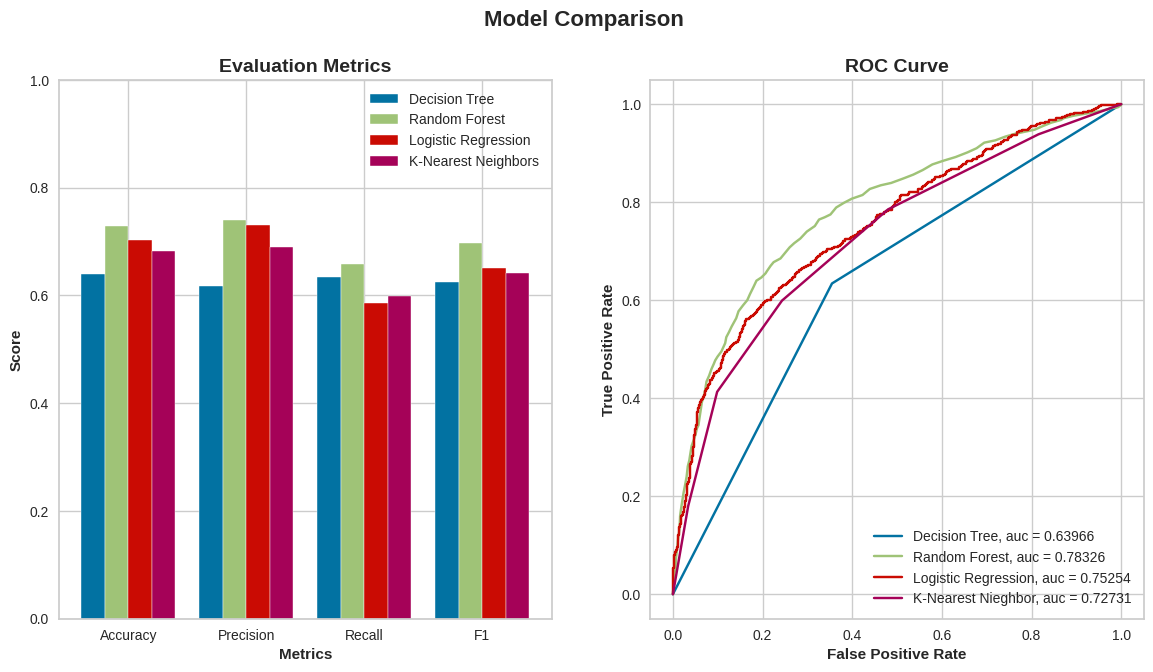

In [37]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1']]
lrc_score = [lrc_eval['acc'], lrc_eval['prec'], lrc_eval['rec'], lrc_eval['f1']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1']]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

## Make the plot
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r3, lrc_score, width=barWidth, edgecolor='white', label='Logistic Regression')
ax1.bar(r4, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(lrc_eval['fpr'], lrc_eval['tpr'], label='Logistic Regression, auc = {:0.5f}'.format(lrc_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

랜덤 포레스트 모델이 평가한 5개의 지표 중 정밀도를 제외한 4개의 지표에서 다른 모델들을 능가합니다. 따라서 랜덤 포레스트가 우리의 문제를 해결하는 데 적합한 선택이라고 결론을 내릴 수 있습니다.

## pycarat

# Model Optimization

하이퍼파라미터를 조정하여 RandomForest 모델을 최적화하려고 합니다. 최적의 파라미터를 찾은 후, 이전의 기본 모델과 비교하여 새로운 모델을 평가할 것입니다.

## 하이퍼파라미터 튜닝

- GridSearchCV 함수는 각 파라미터 조합을 반복하여 가장 좋은 점수를 내는 파라미터를 찾아냅니다.

이 함수는 교차 검증도 사용할 수 있게 해줍니다. 교차 검증에서는 데이터가 5등분(파라미터로 조정 가능)되며, 각 반복에서 5분의 4는 훈련 데이터로 사용되고 나머지 1개는 검증 데이터로 사용됩니다. 이 과정은 모든 데이터 분할이 검증 데이터로 사용될 때까지 5번 반복됩니다.

<div align='center'><img src='https://i.imgur.com/9k60cVA.png' height='200'></div>
어떤 파라미터 조합이 가장 효과적인지 보려면, 그리드 서치 객체에서 best_params_ 속성을 확인할 수 있습니다.

참고: 제공하는 조합이 많을수록 처리 시간이 길어집니다. 대신, RandomizedSearchCV를 사용하여 무작위로 지정된 개수의 파라미터 조합을 선택해 처리 시간을 단축할 수도 있습니다.

![](https://www.researchgate.net/publication/341691661/figure/fig2/AS:896464364507139@1590745168758/Comparison-between-a-grid-search-and-b-random-search-for-hyper-parameter-tuning-The.png)
- 출처: https://www.researchgate.net/publication/341691661/figure/fig2/AS:896464364507139@1590745168758/Comparison-between-a-grid-search-and-b-random-search-for-hyper-parameter-tuning-The.png

```
'acc': 0.7281683833407971,
 'prec': 0.7391304347826086,
 'rec': 0.6587901701323251,
 'f1': 0.6966516741629185,
 ```

In [35]:
rf_eval

{'acc': 0.7281683833407971,
 'prec': 0.7391304347826086,
 'rec': 0.6587901701323251,
 'f1': 0.6966516741629185,
 'fpr': array([0.        , 0.        , 0.00170213, 0.00170213, 0.00255319,
        0.00595745, 0.00680851, 0.0093617 , 0.01191489, 0.01446809,
        0.01531915, 0.01617021, 0.01787234, 0.02042553, 0.02382979,
        0.02723404, 0.0306383 , 0.03319149, 0.03659574, 0.03914894,
        0.04170213, 0.04680851, 0.05021277, 0.05361702, 0.05702128,
        0.05957447, 0.06212766, 0.06468085, 0.06893617, 0.07234043,
        0.07489362, 0.08085106, 0.08595745, 0.09106383, 0.09446809,
        0.09957447, 0.10808511, 0.11659574, 0.11914894, 0.12510638,
        0.13106383, 0.1412766 , 0.14638298, 0.15659574, 0.16595745,
        0.17191489, 0.17957447, 0.18638298, 0.19744681, 0.20680851,
        0.2093617 , 0.21787234, 0.22468085, 0.24      , 0.26042553,
        0.2706383 , 0.28425532, 0.2987234 , 0.31659574, 0.32595745,
        0.3387234 , 0.35148936, 0.36425532, 0.3812766 , 0.3991489

In [36]:
3 * 3 * 3 * 3 * 3 * 5  # n_iter=10

1215

In [37]:
10 * 5

50

In [38]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'max_depth': [50, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500]
}


# 1. 모델을 만듭니다
rfc2 = RandomForestClassifier(random_state=121)

# 2. 모델한테 일을 시킬 CV 객체를 만듭니다.
# 3. CV 객체한테 모델과 파라미터를 넘겨줍니다.
grid_search = RandomizedSearchCV(rfc2, param_grid, cv=5, scoring='recall', n_jobs=-1, refit=True) # n_jobs = -1 병렬적으로 전체 코어를 사용해서 모델을 돌리게 된다.

grid_search.fit(X_train, y_train)

# 4. 최종 결과를 확인합니다.

'''

{'max_depth': 50,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 100}

# {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 4, 'max_depth': 80}

Accuracy: 0.7218987908643081
Precision: 0.7632508833922261
Recall: 0.6067415730337079
F1 Score: 0.676056338028169
Area Under Curve: 0.7882432367266239
Confusion Matrix:
 [[964 201]
 [420 648]]


{'acc': 0.7304075235109718,
 'prec': 0.7645011600928074,
 'rec': 0.6228733459357277,
 'f1': 0.6864583333333334,

'''

"\n\n{'max_depth': 50,\n 'max_features': 4,\n 'min_samples_leaf': 3,\n 'min_samples_split': 12,\n 'n_estimators': 100}\n\n# {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 4, 'max_depth': 80}\n\nAccuracy: 0.7218987908643081\nPrecision: 0.7632508833922261\nRecall: 0.6067415730337079\nF1 Score: 0.676056338028169\nArea Under Curve: 0.7882432367266239\nConfusion Matrix:\n [[964 201]\n [420 648]]\n\n\n{'acc': 0.7304075235109718,\n 'prec': 0.7645011600928074,\n 'rec': 0.6228733459357277,\n 'f1': 0.6864583333333334,\n\n"

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, roc_auc_score, precision_score, accuracy_score, f1_score, confusion_matrix

# 하이퍼파라미터 범위 설정
param_grid = {
    'max_depth': [50, 80, 100],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 300, 500]
}

# 랜덤 포레스트 분류기 초기화
rfc = RandomForestClassifier(random_state=121)

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(rfc, param_grid, cv=5, scoring='recall', n_jobs=-1, refit=True)

# 모델 학습
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터
best_params = random_search.best_params_

# 테스트 데이터로 예측 수행
y_pred = random_search.predict(X_test)
y_pred_proba = random_search.predict_proba(X_test)[:, 1]

# 성능 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# 결과 출력
print(f"최적 하이퍼파라미터: {best_params}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Area Under Curve: {auc}")
print(f"Confusion Matrix:\n {conf_matrix}")


최적 하이퍼파라미터: {'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 4, 'max_depth': 80}
Accuracy: 0.729064039408867
Precision: 0.7649122807017544
Recall: 0.6181474480151229
F1 Score: 0.683742812336644
Area Under Curve: 0.7854683666492378
Confusion Matrix:
 [[974 201]
 [404 654]]


In [40]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE

# SMOTE로 불균형 데이터 처리
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# XGBoost 분류기 생성
xgb_clf = xgb.XGBClassifier(random_state=121, use_label_encoder=False, eval_metric='logloss')

# 하이퍼파라미터 그리드 설정
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'colsample_bytree': [0.3, 0.7]
}

# GridSearchCV를 사용하여 최적의 모델 탐색
grid_search = GridSearchCV(xgb_clf, param_grid, cv=StratifiedKFold(n_splits=5), scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_res, y_res)

# 최적의 모델로 예측
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

# 성능 평가
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits
Accuracy: 0.7411553963278101
Precision: 0.7631578947368421
Recall: 0.6578449905482041
F1 Score: 0.7065989847715736
AUC: 0.7960262237059084


In [41]:
best_grid_eval = evaluate_model(grid_search, X_test, y_test)

In [42]:
best_grid_eval

{'acc': 0.7411553963278101,
 'prec': 0.7631578947368421,
 'rec': 0.6578449905482041,
 'f1': 0.7065989847715736,
 'fpr': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.51063830e-04,
        8.51063830e-04, 1.70212766e-03, 1.70212766e-03, 2.55319149e-03,
        2.55319149e-03, 3.40425532e-03, 3.40425532e-03, 4.25531915e-03,
        4.25531915e-03, 5.10638298e-03, 5.10638298e-03, 5.95744681e-03,
        5.95744681e-03, 6.80851064e-03, 6.80851064e-03, 7.65957447e-03,
        7.65957447e-03, 8.51063830e-03, 8.51063830e-03, 9.36170213e-03,
        9.36170213e-03, 1.02127660e-02, 1.02127660e-02, 1.10638298e-02,
        1.10638298e-02, 1.19148936e-02, 1.19148936e-02, 1.27659574e-02,
        1.27659574e-02, 1.36170213e-02, 1.36170213e-02, 1.44680851e-02,
        1.44680851e-02, 1.53191489e-02, 1.53191489e-02, 1.61702128e-02,
        1.61702128e-02, 1.70212766e-02, 1.70212766e-02, 1.78723404e-02,
        1.78723404e-02, 1.87234043e-02, 1.87234043e-02, 2.04255319e-02,
        2.0425531

In [43]:
print(grid_search.best_params_)
print(pd.DataFrame(grid_search.cv_results_))

{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        3.53e-01      1.30e-02         2.69e-02        1.28e-03   
1        6.15e-01      2.41e-02         3.27e-02        1.49e-03   
2        9.35e-01      2.73e-02         3.97e-02        2.20e-03   
3        3.63e-01      3.75e-02         3.25e-02        1.70e-03   
4        7.98e-01      4.00e-02         4.33e-02        2.66e-03   
5        1.31e+00      1.01e-01         5.22e-02        2.73e-03   
6        4.59e-01      5.29e-02         5.04e-02        1.84e-02   
7        1.23e+00      1.36e-01         5.15e-02        6.26e-03   
8        1.85e+00      1.84e-01         7.12e-02        9.22e-03   
9        2.87e-01      3.12e-02         2.77e-02        2.10e-03   
10       5.99e-01      4.10e-02         3.41e-02        1.05e-03   
11       9.14e-01      6.02e-02         5.65e-02        2.37e-02   
12       3.17e-01      3.29e-02

In [44]:
dir(grid_search)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_check_refit_for_multimetric',
 '_estimator_type',
 '_format_results',
 '_get_default_requests',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_run_search',
 '_select_best_index',
 '_validate_data',
 '_validate_params',
 'best_estimator_',
 'best_index_',
 'best_params_',
 'best_score_',
 '

## 최적화된 모델 평가

모델에 대한 최적의 파라미터를 찾은 후, `GridSearchCV` 객체의 `best_estimator_` 속성을 사용하여 최적화된 모델을 `best_grid`라는 변수에 저장할 수 있습니다. 이후, 함수를 사용하여 5가지 평가 지표를 계산하고 다음 단계에서 기본 모델과 비교해보겠습니다.

In [45]:


# Print result
print('Accuracy:', best_grid_eval['acc'])
print('Precision:', best_grid_eval['prec'])
print('Recall:', best_grid_eval['rec'])
print('F1 Score:', best_grid_eval['f1'])
print('Area Under Curve:', best_grid_eval['auc'])
print('Confusion Matrix:\n', best_grid_eval['cm'])

Accuracy: 0.7411553963278101
Precision: 0.7631578947368421
Recall: 0.6578449905482041
F1 Score: 0.7065989847715736
Area Under Curve: 0.7960262237059084
Confusion Matrix:
 [[959 216]
 [362 696]]


### pycaret

In [51]:
selected_features

,Feature
0,job_admin.
1,job_blue-collar
4,job_management
7,job_services
9,job_technician
13,marital_married
14,marital_single
15,education_primary
16,education_secondary
17,education_tertiary


In [ ]:
# 특성 선택
# selected_features는 피처 이름들의 리스트이므로, 이를 df_bank_ready에서 선택해야 합니다.
feature = df_bank_ready[selected_features]  # 선택된 피처를 데이터프레임에서 추출
target = df_bank_ready['deposit']

# 훈련 데이터와 테스트 데이터 설정
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, shuffle=True, random_state=121)

# Pycaret 설치 (Jupyter 환경에서 pip 사용)
!pip install pycaret

# Pycaret을 사용한 AutoML
from pycaret.classification import *
import pandas as pd  # pandas 라이브러리 임포트

# Pycaret에서 사용할 데이터 준비
# 훈련 데이터 (특성 + 타겟) 결합
df = pd.concat([X_train, y_train], axis=1)

# Pycaret 초기화
clf = setup(data=df, target='deposit', session_id=42)  # 'deposit'을 타겟으로 설정

# 다양한 모델 비교
best_model = compare_models()

# 최적의 모델 출력
print(best_model)


,Description,Value
0,Session id,42
1,Target,deposit
2,Target type,Binary
3,Original data shape,"(8929, 32)"
4,Transformed data shape,"(8929, 32)"
5,Transformed train set shape,"(6250, 32)"
6,Transformed test set shape,"(2679, 32)"
7,Numeric features,31
8,Preprocess,True
9,Imputation type,simple


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,06:43:57
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7230,0.7813,0.6064,0.7611,0.6749,0.4389,0.4477,0.2050
xgboost,Extreme Gradient Boosting,0.7094,0.7630,0.6486,0.7127,0.6790,0.4147,0.4163,0.0560
ada,Ada Boost Classifier,0.7093,0.7658,0.6003,0.7377,0.6618,0.4116,0.4184,0.0760
rf,Random Forest Classifier,0.7090,0.7652,0.6286,0.7213,0.6717,0.4126,0.4158,0.1760
lr,Logistic Regression,0.6931,0.7531,0.5885,0.7142,0.6449,0.3792,0.3850,0.4690
lda,Linear Discriminant Analysis,0.6912,0.7523,0.5861,0.7119,0.6426,0.3753,0.3810,0.0130
ridge,Ridge Classifier,0.6910,0.7523,0.5861,0.7116,0.6425,0.3750,0.3807,0.0130
et,Extra Trees Classifier,0.6778,0.7413,0.6182,0.6748,0.6450,0.3511,0.3523,0.1740
knn,K Neighbors Classifier,0.6739,0.7142,0.5915,0.6794,0.6322,0.3419,0.3447,0.0370
nb,Naive Bayes,0.6725,0.7391,0.4625,0.7507,0.5722,0.3304,0.3560,0.0140


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [2]:
!pip install pycaret

# Pycaret을 사용한 AutoML
from pycaret.classification import *
import pandas as pd  # pandas 라이브러리 임포트
# 데이터 준비
df = pd.concat([X_train, y_train], axis=1)

# Pycaret 초기화
clf = setup(data=df, target='target_column', session_id=42)

# 다양한 모델 비교
best_model = compare_models()

# 최적의 모델 출력
print(best_model)


NameError: name 'X_train' is not defined

## 모델 비교

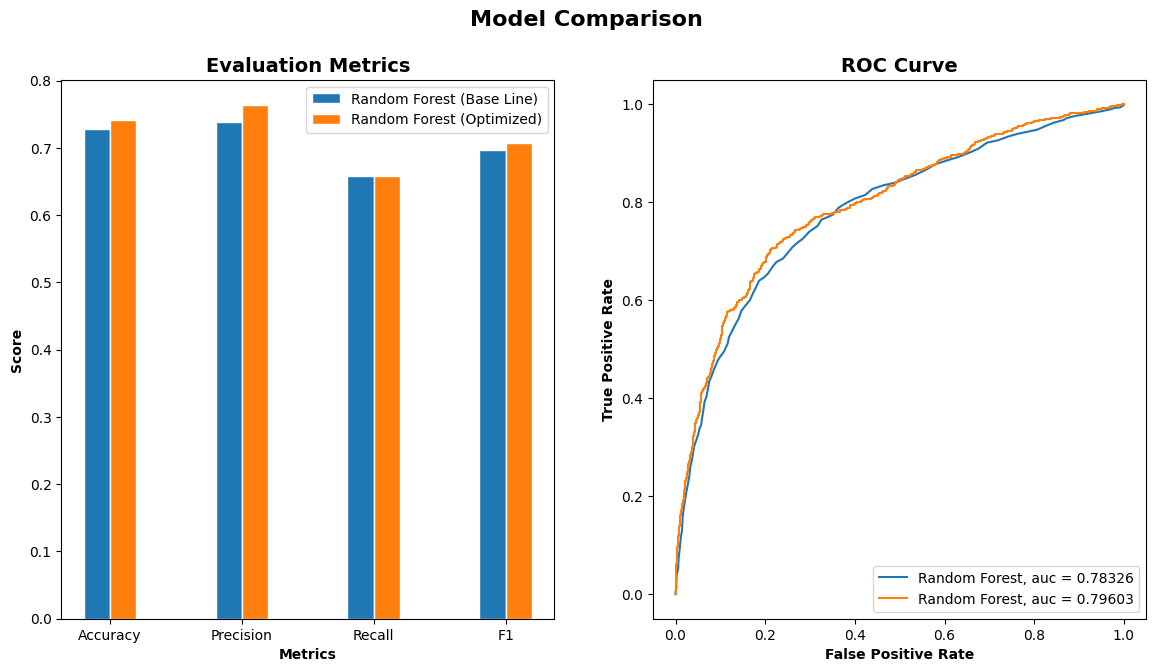

Change of 1.78% on accuracy.
Change of 3.25% on precision.
Change of -0.14% on recall.
Change of 1.43% on F1 score.
Change of 1.63% on AUC.


In [46]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1']]
best_grid_score = [best_grid_eval['acc'], best_grid_eval['prec'], best_grid_eval['rec'], best_grid_eval['f1']]

## Set position of bar on X axis
r1 = np.arange(len(rf_score))
r2 = [x + barWidth for x in r1]

## Make the plot
ax1.bar(r1, rf_score, width=barWidth, edgecolor='white', label='Random Forest (Base Line)')
ax1.bar(r2, best_grid_score, width=barWidth, edgecolor='white', label='Random Forest (Optimized)')

## Add xticks on the middle of the group bars
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
ax1.set_xticks([r + (barWidth * 0.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
# ax1.set_ylim(0, 1)

## Create legend & Show graphic
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(best_grid_eval['fpr'], best_grid_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(best_grid_eval['auc']))

ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.legend(loc=4)

plt.show()

print('Change of {:0.2f}% on accuracy.'.format(100 * ((best_grid_eval['acc'] - rf_eval['acc']) / rf_eval['acc'])))
print('Change of {:0.2f}% on precision.'.format(100 * ((best_grid_eval['prec'] - rf_eval['prec']) / rf_eval['prec'])))
print('Change of {:0.2f}% on recall.'.format(100 * ((best_grid_eval['rec'] - rf_eval['rec']) / rf_eval['rec'])))
print('Change of {:0.2f}% on F1 score.'.format(100 * ((best_grid_eval['f1'] - rf_eval['f1']) / rf_eval['f1'])))
print('Change of {:0.2f}% on AUC.'.format(100 * ((best_grid_eval['auc'] - rf_eval['auc']) / rf_eval['auc'])))

우리는 가능한 한 실제 양성 값을 많이 예측하는 것이 목표이기 때문에, 아쉽지만 재현율 점수가 더 높은 원래 모델을 예측에 사용하겠습니다.

# Output

`joblib` 모듈을 사용하여 모델을 저장하고 불러오면, 프로덕션에서 사용하거나 나중에 사용할 수 있도록 모델을 저장할 수 있어 훈련 과정을 반복할 필요가 없습니다.

## Prediction

데이터셋의 모든 행에 대한 예상 결과를 예측한 후, 나중에 더 쉽게 접근할 수 있도록 이를 CSV 파일로 저장할 것입니다.

In [ ]:
df_bank['deposit_prediction'] = rf.predict(feature)
df_bank['deposit_prediction'] = df_bank['deposit_prediction'].apply(lambda x : 'yes' if x==1 else 'no')
df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,deposit_prediction
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,no
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,no
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,no
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no,no
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no,no
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no,no


In [ ]:
df_bank.to_csv('deposit_prediction.csv', index=False)

## 모델 저장

In [ ]:
from joblib import dump, load

# 모델을 바이너리 데이터로 저장을 합니다. 확장자를 모듈명으로 보통 저장합니다.
dump(rf, 'bank_deposit_classification_2409131227.joblib')

['bank_deposit_classification_2409131227.joblib']

In [ ]:
new_clf = load('bank_deposit_classification_2409131227.joblib')

In [ ]:
new_clf.predict(feature)

array([1, 0, 1, ..., 0, 0, 1])

In [ ]:
 evaluate_model(new_clf, X_test, y_test)

{'acc': 0.7281683833407971,
 'prec': 0.7391304347826086,
 'rec': 0.6587901701323251,
 'f1': 0.6966516741629185,
 'fpr': array([0.        , 0.        , 0.00170213, 0.00170213, 0.00255319,
        0.00595745, 0.00680851, 0.0093617 , 0.01191489, 0.01446809,
        0.01531915, 0.01617021, 0.01787234, 0.02042553, 0.02382979,
        0.02723404, 0.0306383 , 0.03319149, 0.03659574, 0.03914894,
        0.04170213, 0.04680851, 0.05021277, 0.05361702, 0.05702128,
        0.05957447, 0.06212766, 0.06468085, 0.06893617, 0.07234043,
        0.07489362, 0.08085106, 0.08595745, 0.09106383, 0.09446809,
        0.09957447, 0.10808511, 0.11659574, 0.11914894, 0.12510638,
        0.13106383, 0.1412766 , 0.14638298, 0.15659574, 0.16595745,
        0.17191489, 0.17957447, 0.18638298, 0.19744681, 0.20680851,
        0.2093617 , 0.21787234, 0.22468085, 0.24      , 0.26042553,
        0.2706383 , 0.28425532, 0.2987234 , 0.31659574, 0.32595745,
        0.3387234 , 0.35148936, 0.36425532, 0.3812766 , 0.3991489

# 결론

간단한 모델이지만, 데이터를 분류하는 데에 꽤 괜찮은 성능을 보였습니다. 그러나 모델에는 아직 몇 가지 약점이 있으며, 특히 재현율(Recall) 지표에서 약 60%에 그친다는 점이 눈에 띕니다. 이는 모델이 잠재 고객의 60%만 탐지하고 나머지 40%는 놓친다는 의미입니다. `GridSearchCV`로 모델을 최적화한 후에도 결과가 크게 달라지지 않았는데, 이는 이 모델의 한계에 도달했을 가능성을 시사합니다.

성능을 개선하기 위해 다른 알고리즘들을 시도해 볼 수 있습니다.

# 참고

1. Kaggle Dataset - https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset
2. Telkom Digital Talent Incubator - Data Scientist Module 5 (Classification)
3. [Scikit-learn Documentation](https://scikit-learn.org/stable/index.html)
4. [The 5 Classification Evaluation metrics every Data Scientist must know](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226)
5. [The Python Graph Gallery - Grouped Bar Plot](https://python-graph-gallery.com/11-grouped-barplot/)